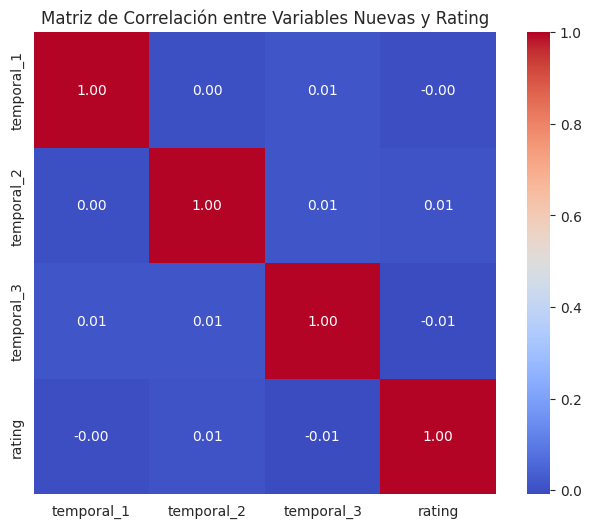


📊 Correlación de Variables con Rating:

temporal_2    0.008631
temporal_1   -0.000926
temporal_3   -0.008611
Name: rating, dtype: float64


In [2]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 1. Cargar tu dataset limpio (el que tiene temporal_1, temporal_2, temporal_3, etc.)
df = pd.read_csv("dataset_final.csv")

# 🔹 2. Seleccionar las columnas que quieres analizar
features = ['temporal_1', 'temporal_2', 'temporal_3']  # puedes agregar más si tienes
features.append('rating')  # agregamos el rating para la correlación

# 🔹 3. Calcular la matriz de correlación
correlation_matrix = df[features].corr()

# 🔹 4. Visualizar la matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de Correlación entre Variables Nuevas y Rating")
plt.show()

correlation_with_rating = correlation_matrix['rating'].drop('rating').sort_values(ascending=False)

print("\n📊 Correlación de Variables con Rating:\n")
print(correlation_with_rating)


In [3]:

import pandas as pd
import numpy as np
from fastFM import sgd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy import sparse

df = pd.read_csv("dataset_final.csv")

X = df[['temporal_1', 'temporal_2', 'temporal_3']]
y = df['rating']

# 🔹 3. Normalizar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir a sparse matrix (porque fastFM necesita sparse)
X_sparse = sparse.csr_matrix(X_scaled)

# 🔹 4. Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)

# 🔹 5. Crear el modelo Factorization Machine
fm = sgd.FMRegression(n_iter=1000, init_stdev=0.1, l2_reg_w=0.1, l2_reg_V=0.5, rank=8, random_state=42)

# 🔹 6. Entrenar el modelo
fm.fit(X_train, y_train)

# 🔹 7. Predecir
y_pred = fm.predict(X_test)

# 🔹 8. Evaluar con RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n🔍 RMSE obtenido en test: {rmse:.4f}")




🔍 RMSE obtenido en test: 1.3025


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# 🔹 1. Cargar el dataset final con features y UMAP
df = pd.read_csv("dataset_final.csv")

# 🔹 2. Definir features y target
features = [
    'userId', 'movieId',
    'temporal_1', 'temporal_2', 'temporal_3',
    'rating_previous', 'is_weekend', 'season_encoded', 'is_holiday',
    'year', 'month', 'weekday',
    'consumo_semanal_usuario', 'antiguedad_rating', 'diferencia_rating_anterior'
]

X = df[features]
y = df['rating']

# 🔹 3. Partir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
# Mostrar las primeras filas del dataframe final antes de entrenar
print(df[features].head(100))  # Muestra 10 ejemplos


    userId  movieId  temporal_1  temporal_2  temporal_3  rating_previous  \
0        1      541    5.138229   10.480572    6.200244              0.0   
1        1      166  -10.257247    5.335088    1.286286              5.0   
2        1     1784  -10.259111    5.336805    1.284552              5.0   
3        1     1944   15.531549   17.675604   -1.268866              1.0   
4        1     1208   -4.956165    2.693344    3.844622              2.0   
..     ...      ...         ...         ...         ...              ...   
95      10     2700    0.632457    3.183998    6.524270              2.0   
96      10     5349   -3.244154    7.316803   -6.622593              3.5   
97      10     3418   14.844016    7.448882   10.789434              3.0   
98      10     3527    5.657960    7.992783   10.928692              2.5   
99      10     1876   14.844016    7.448882   10.789434              3.0   

    is_weekend  season_encoded  is_holiday  year  month  weekday  \
0            1     

In [6]:
# 🔹 Separar entradas individuales
X_train_user = X_train['userId'].values
X_train_movie = X_train['movieId'].values
X_train_others = X_train.drop(['userId', 'movieId'], axis=1).values
X_train_others = X_train_others.reshape((X_train_others.shape[0], 1, X_train_others.shape[1]))

X_test_user = X_test['userId'].values
X_test_movie = X_test['movieId'].values
X_test_others = X_test.drop(['userId', 'movieId'], axis=1).values
X_test_others = X_test_others.reshape((X_test_others.shape[0], 1, X_test_others.shape[1]))


In [7]:
# 📚 Importar librerías necesarias
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, SimpleRNN
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf

# 🔹 Cargar el dataset final ya procesado
df = pd.read_csv("dataset_final.csv")  # Asegúrate que tiene las columnas correctas

# 🔹 1. Mapear userId y movieId a índices únicos
unique_users = df['userId'].unique()
unique_movies = df['movieId'].unique()

user_id_map = {uid: idx for idx, uid in enumerate(unique_users)}
movie_id_map = {mid: idx for idx, mid in enumerate(unique_movies)}

df['userId'] = df['userId'].map(user_id_map)
df['movieId'] = df['movieId'].map(movie_id_map)

# 🔹 2. Guardar los diccionarios para predicción
joblib.dump(user_id_map, 'user_id_map.pkl')
joblib.dump(movie_id_map, 'movie_id_map.pkl')

# 🔹 3. Separar variables
X_user = df['userId'].values
X_movie = df['movieId'].values

feature_cols = [
    'temporal_1', 'temporal_2', 'temporal_3',
    'rating_previous', 'is_weekend', 'season_encoded', 'is_holiday',
    'year', 'month', 'weekday',
    'consumo_semanal_usuario', 'antiguedad_rating', 'diferencia_rating_anterior'
]
X_others = df[feature_cols].values.reshape((df.shape[0], 1, len(feature_cols)))
y = df['rating'].values

# 🔹 4. División en train/test
from sklearn.model_selection import train_test_split
X_train_user, X_test_user, X_train_movie, X_test_movie, X_train_others, X_test_others, y_train, y_test = train_test_split(
    X_user, X_movie, X_others, y, test_size=0.2, random_state=42
)

# 🔹 5. Definir dimensiones de los embeddings
n_users = len(user_id_map)
n_movies = len(movie_id_map)

# 🔹 6. Definir Inputs
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
other_features_input = Input(shape=(1, 13), name='other_features_input')

# 🔹 7. Embeddings
user_embedding = Embedding(input_dim=n_users+1, output_dim=16, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=n_movies+1, output_dim=16, name='movie_embedding')(movie_input)

user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

embedding_concat = Concatenate()([user_vec, movie_vec])
embedding_concat = tf.expand_dims(embedding_concat, axis=1)

# 🔹 8. Combinar embeddings + otras features
combined = Concatenate(axis=-1)([embedding_concat, other_features_input])

# 🔹 9. RNN + Densas
rnn_out = SimpleRNN(128, activation='tanh')(combined)
dense1 = Dense(64, activation='relu')(rnn_out)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# 🔹 10. Modelo
model = Model(inputs=[user_input, movie_input, other_features_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

# 🔹 11. Entrenamiento
history = model.fit(
    [X_train_user, X_train_movie, X_train_others], y_train,
    validation_data=([X_test_user, X_test_movie, X_test_others], y_test),
    epochs=10,
    batch_size=1024,
    verbose=1
)

# 🔹 12. Evaluación
loss, rmse = model.evaluate([X_test_user, X_test_movie, X_test_others], y_test, verbose=1)
print(f"\n✅ RMSE final de la RNN Pro mejorada: {rmse:.4f}")

# 🔹 13. Métricas adicionales
y_pred_continuous = model.predict([X_test_user, X_test_movie, X_test_others]).flatten()
rmse_manual = np.sqrt(mean_squared_error(y_test, y_pred_continuous))
print(f"✅ RMSE (manual check): {rmse_manual:.4f}")

y_pred_class = np.round(y_pred_continuous)
y_true_class = np.round(y_test)

accuracy = accuracy_score(y_true_class, y_pred_class)
precision = precision_score(y_true_class, y_pred_class, average='weighted', zero_division=0)
recall = recall_score(y_true_class, y_pred_class, average='weighted')
f1 = f1_score(y_true_class, y_pred_class, average='weighted')

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1-Score: {f1:.4f}")

# 🔹 14. Guardar modelo
model.save("modelo_rnnxd.h5")
print("✅ Modelo y mapas guardados exitosamente.")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 16)                3206160   ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 16)                814080    ['movie_input[0][0]']         
 )                                                                                            

2025-05-09 05:47:55.846446: I external/local_xla/xla/service/service.cc:168] XLA service 0x593bc617c100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-09 05:47:55.846478: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-05-09 05:47:55.871269: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-09 05:47:55.937190: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1746787676.020261    6795 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4167/4167 [==============================] - 39s 9ms/step - loss: 0.1633 - root_mean_squared_error: 0.4041 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 2/10
4167/4167 [==============================] - 25s 6ms/step - loss: 0.0278 - root_mean_squared_error: 0.1669 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0659
Epoch 3/10
4167/4167 [==============================] - 25s 6ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 4/10
4167/4167 [==============================] - 25s 6ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0872 - val_root_mean_squared_error: 0.2953
Epoch 5/10
4167/4167 [==============================] - 25s 6ms/step - loss: 0.0108 - root_mean_squared_error: 0.1041 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0697
Epoch 6/10
4167/4167 [==============================] - 26s 6ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0052

/home/eduardo/PycharmProjects/Calculo_Entropia/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
# 📚 Predecir en el test set
y_pred_continuous = model.predict([X_test_user, X_test_movie, X_test_others]).flatten()

# 🔹 Seleccionamos 5 ejemplos aleatorios para mostrar
import random

# Escogemos 5 índices aleatorios
random_indices = random.sample(range(len(y_test)), 5)

print("\n Ejemplos de predicción:\n")
for idx in random_indices:
    print(f"Usuario ID: {X_test_user[idx]}")
    print(f"Película ID: {X_test_movie[idx]}")
    print(f"Rating real: {y_test.iloc[idx]:.1f}")
    print(f"Rating predicho: {y_pred_continuous[idx]:.2f}")
    print("-" * 40)


33334/33334 [==============================] - 47s 1ms/step

 Ejemplos de predicción:

Usuario ID: 57248
Película ID: 1704


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [9]:
# 📚 Análisis estadístico de las predicciones
import numpy as np

min_rating = np.min(y_pred_continuous)
max_rating = np.max(y_pred_continuous)
mean_rating = np.mean(y_pred_continuous)
std_rating = np.std(y_pred_continuous)

print("\n Análisis de las predicciones:\n")
print(f" Mínimo rating predicho: {min_rating:.2f}")
print(f" Máximo rating predicho: {max_rating:.2f}")
print(f" Promedio de ratings predichos: {mean_rating:.2f}")
print(f" Desviación estándar de ratings predichos: {std_rating:.2f}")



 Análisis de las predicciones:

 Mínimo rating predicho: 0.87
 Máximo rating predicho: 4.99
 Promedio de ratings predichos: 3.56
 Desviación estándar de ratings predichos: 1.05


In [19]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import holidays

# ==== 1. CARGAR MODELO Y MAPAS ====
model = load_model("modelo_rnnxd.h5")
user_id_map = joblib.load("user_id_map.pkl")
movie_id_map = joblib.load("movie_id_map.pkl")
umap_model = joblib.load("umap_model.pkl")
scaler = joblib.load("scaler_temporal.pkl")

# ==== 2. CARGAR NUEVO DATASET (sin 'rating') ====
df_new = pd.read_csv("test.csv", delimiter=';')

# ==== 3. FILTRAR IDs NO VISTOS ====
df_new = df_new[df_new['userId'].isin(user_id_map)]
df_new = df_new[df_new['movieId'].isin(movie_id_map)]

# ==== 4. MAPEAR IDs ====
df_new['userId'] = df_new['userId'].map(user_id_map)
df_new['movieId'] = df_new['movieId'].map(movie_id_map)

# ==== 5. PROCESAMIENTO TEMPORAL ====
df_new['date'] = pd.to_datetime(df_new['timestamp'], unit='s')
df_new['year'] = df_new['date'].dt.year
df_new['month'] = df_new['date'].dt.month
df_new['weekday'] = df_new['date'].dt.weekday
df_new['week_of_year'] = df_new['date'].dt.isocalendar().week.astype(int)

# Temporada
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Invierno
    elif month in [3, 4, 5]:
        return 1  # Primavera
    elif month in [6, 7, 8]:
        return 2  # Verano
    else:
        return 3  # Otoño

df_new['season_encoded'] = df_new['month'].apply(get_season)
df_new['is_weekend'] = df_new['weekday'].isin([5, 6]).astype(int)

# Feriado
ecu_holidays = holidays.Ecuador(years=range(df_new['year'].min(), df_new['year'].max() + 1))
df_new['is_holiday'] = df_new['date'].isin(ecu_holidays).astype(int)

# ==== 6. SIMULAR LAS FEATURES QUE NO TIENES ====
# Aquí no usamos `rating`, ya que lo que queremos es predecirlo
# Vamos a simular algunas columnas más dinámicas:

# Utilizamos una media para `rating_previous` o un valor aleatorio en un rango razonable
df_new['rating_previous'] = np.random.choice([2.5, 3, 3.5], size=len(df_new), replace=True)

# Calculamos la diferencia entre el rating actual y el anterior
df_new['diferencia_rating_anterior'] = np.random.normal(0, 0.5, size=len(df_new))  # Simulamos una diferencia

# Calculamos antiguedad_rating (en el entrenamiento lo calculamos con base en el año)
df_new['antiguedad_rating'] = 2025 - df_new['year']  # 2025 es el año actual en este contexto

# Consumo semanal simulado
consumo = df_new.groupby(['userId', 'week_of_year']).size().reset_index(name='consumo_semanal_usuario')
df_new = pd.merge(df_new, consumo, on=['userId', 'week_of_year'], how='left')
df_new['consumo_semanal_usuario'].fillna(df_new['consumo_semanal_usuario'].mean(), inplace=True)

# ==== 7. GENERAR FEATURES TEMPORALES CON SCALER + UMAP ====
temporal_features = ['year', 'month', 'weekday', 'season_encoded', 'is_weekend', 'is_holiday', 'rating_previous']
X_temporal_scaled = scaler.transform(df_new[temporal_features])
df_new[['temporal_1', 'temporal_2', 'temporal_3']] = umap_model.transform(X_temporal_scaled)

# ==== 8. PREPARAR ENTRADAS PARA PREDICCIÓN ====
features_finales = [
    'temporal_1', 'temporal_2', 'temporal_3',
    'rating_previous', 'is_weekend', 'season_encoded', 'is_holiday',
    'year', 'month', 'weekday',
    'consumo_semanal_usuario', 'antiguedad_rating', 'diferencia_rating_anterior'
]

X_user = df_new['userId'].values
X_movie = df_new['movieId'].values
X_others = df_new[features_finales].values.reshape((df_new.shape[0], 1, len(features_finales)))

# ==== 9. HACER PREDICCIONES ====
y_pred = model.predict([X_user, X_movie, X_others]).flatten()

# ==== 10. REDONDEAR A VALORES POSIBLES ====
rating_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
y_pred_rounded = np.array([min(rating_values, key=lambda x: abs(x - pred)) for pred in y_pred])

# ==== 11. EXPORTAR RESULTADOS ====
df_new['predicted_rating'] = y_pred_rounded
df_new[['userId', 'movieId', 'predicted_rating']].to_excel("predicciones_rnn_final.xlsx", index=False)

print("✅ Predicciones generadas y guardadas como 'predicciones_rnn_final.xlsx'")


/tmp/ipykernel_6722/2316432150.py:49: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_new['is_holiday'] = df_new['date'].isin(ecu_holidays).astype(int)
/tmp/ipykernel_6722/2316432150.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_new['consumo_semanal_usuario'].fillna(df_new['consumo_semanal_usuario'].mean(), inpl

32650/32650 [==============================] - 49s 1ms/step
✅ Predicciones generadas y guardadas como 'predicciones_rnn_final.xlsx'
